Converged after 106900 iterations.
Total cost: 57118.76171875
Number of SOC violations: 14
SOC at the end of the period: 0.00
Optimized Pg: [ 7.4248405  7.0342326  8.155938   7.6142297  7.6058083  6.169439
  6.8951845  5.796001   6.8204775  6.5536485  6.3053827  7.673676
  8.105515   9.170431   8.803244   8.814784   8.253697   8.515955
  7.1211557  7.0613914  7.732808   7.6562505  6.1351695  5.699259
  5.9114857  5.985466   4.6684556  5.869979   5.286968   6.274084
  5.8942065  6.8381133  7.7759857  9.428181   9.408495  10.
 10.         9.900001   9.900001   9.269514  10.         8.768068
  9.475409   9.494334   9.555684   8.453576   8.404      7.4001555]
Optimized Pb: [ 0.6223512   0.91278124 -0.49480748 -0.07228351 -0.3246479   0.8700009
 -0.11574173  0.99000007 -0.00238633  0.24382058  0.83408237 -0.03278948
  0.25833657 -0.1519497   0.89000076  0.9400004   1.          0.06543799
  0.8635549   0.4821207  -0.5099595  -0.6289227   0.7227821   0.8100013
  0.2462754  -0.208029    0.8600

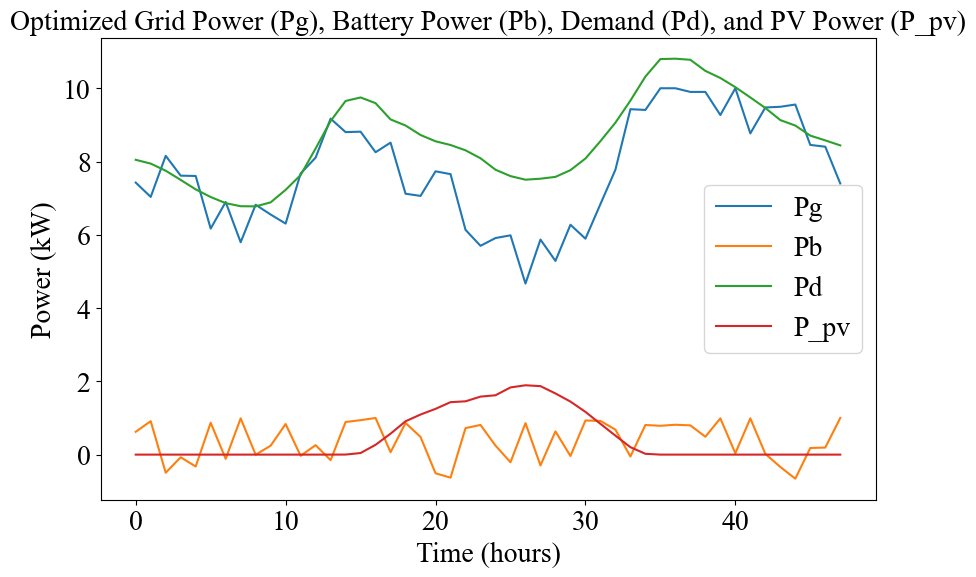

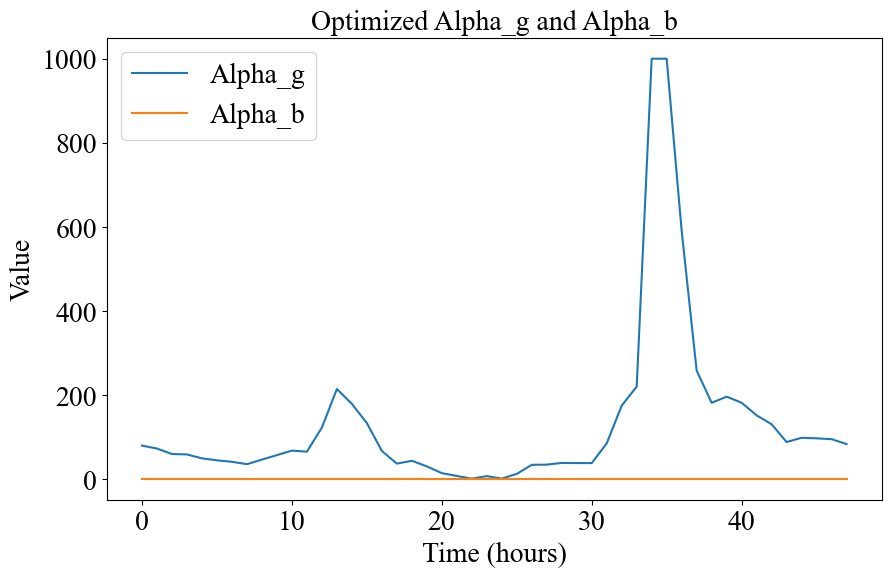

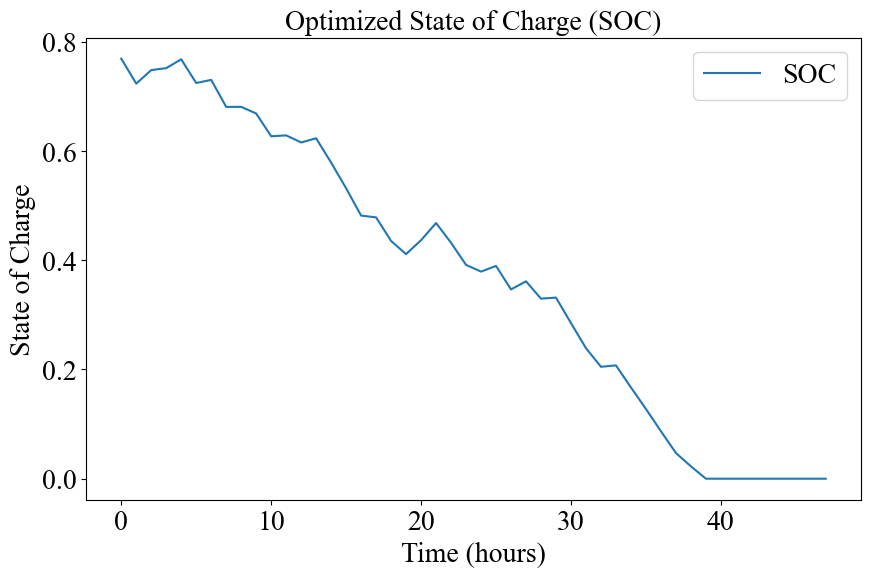

In [1]:
#NSW Testing 

import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Input data

P_pv = np.array( [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.376, 43.075, 267.996, 571.332, 909.973, 1094.175, 1248.706, 1432.081, 1454.66, 1582.929, 1620.056, 1833.422, 1892.649, 1868.952, 1669.518, 1447.044, 1166.468, 840.143, 517.692, 202.727, 21.929, 0.057, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])/1000

P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])/1000
#Cg_t = np.random.uniform(low=10, high=15, size=48)/1000
Cg_t =  np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])/100

Cb_t = np.random.uniform(low=0, high=20, size=48)/100

unc_P_pv= np.random.normal(loc=0, scale=0.10, size=48) * P_pv
unc_P_d= np.random.normal(loc=0, scale=0.10, size=48) * P_d
unc_Cg_t = np.random.normal(loc=0, scale=0.10, size=48) * Cg_t
unc_Cb_t= np.random.normal(loc=0, scale=0.10, size=48) * Cb_t

P_unc = unc_P_pv + unc_P_d + unc_Cg_t + unc_Cb_t

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -10
Pg_max = np.ones(48) * 10  # Example of maximum grid power
Pb_min = np.ones(48) * -1 # Example of minimum battery power
Pb_max = np.ones(48) * 1  # Example of maximum battery power
battery_capacity = 20  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())
#total_cost = np.sum(Pg_t.numpy() * Cg_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Power (kW)", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)", fontsize=20)
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Alpha_g and Alpha_b", fontsize=20)
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("State of Charge", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized State of Charge (SOC)", fontsize=20)
plt.show()








Converged after 105800 iterations.
Total cost: 49025.15625
Number of SOC violations: 11
SOC at the end of the period: 0.04
Optimized Pg: [5.4273863 4.8739624 5.9791555 5.7799573 5.6940637 4.3286066 5.6566234
 4.5271974 5.4043307 5.4175487 5.043764  6.0015693 6.1238575 6.7893
 5.7922726 5.6203513 4.8875923 5.0111737 3.3348184 3.0929844 3.6829758
 3.5693855 1.8846326 1.5594956 2.3680496 2.6198354 1.8979262 3.1789904
 2.5508842 3.7418628 3.515948  4.3166823 5.213191  7.        6.695946
 7.        7.        7.        7.        6.238661  7.        5.8476496
 6.742785  6.816033  7.        6.147501  6.112799  4.8701105]
Optimized Pb: [ 0.44235247  0.79278207 -0.39480814 -0.25228226 -0.24464844  0.98000014
 -0.21574104  0.99000007  0.11761169  0.26382047  0.8740821   0.10720664
  0.41833547 -0.0319501   0.9700002   0.83004695  0.82924116 -0.11456078
  0.6635563   0.26212218 -0.70995814 -0.8489212   0.58278304  0.78833413
  0.00627718 -0.1480294   0.7854448  -0.25555193  0.61375093 -0.05849625


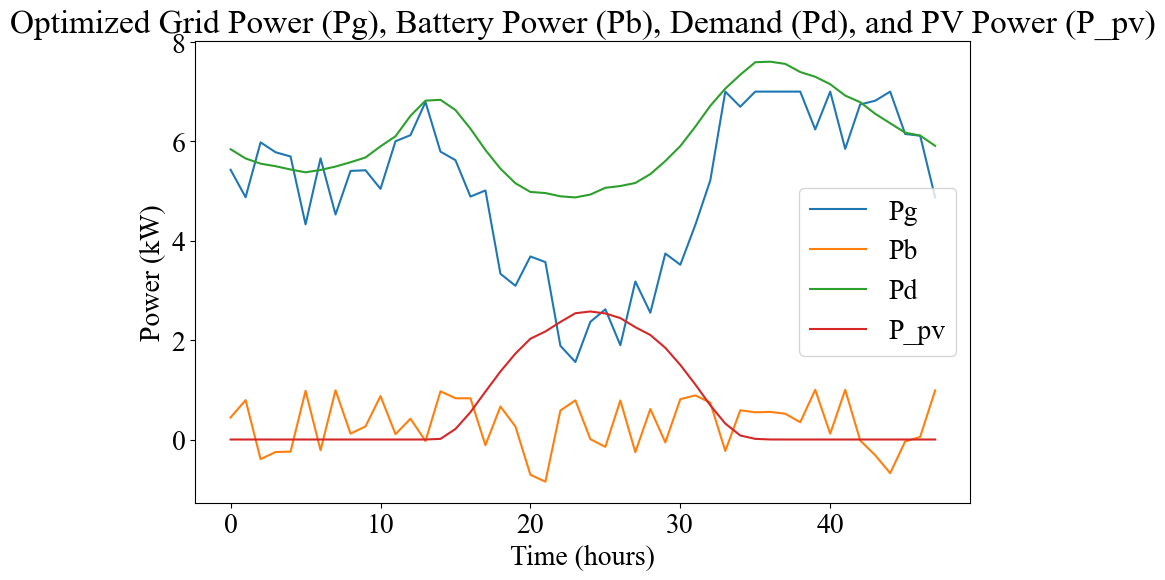

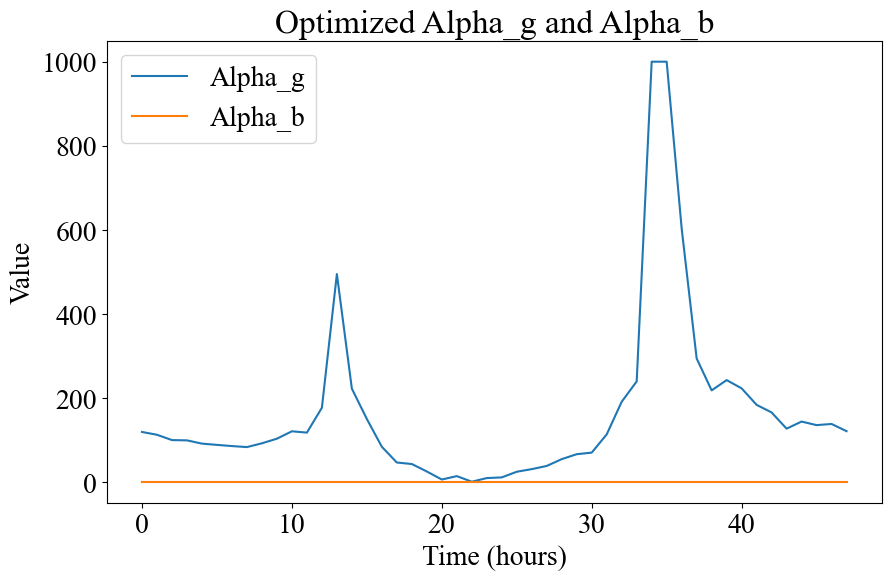

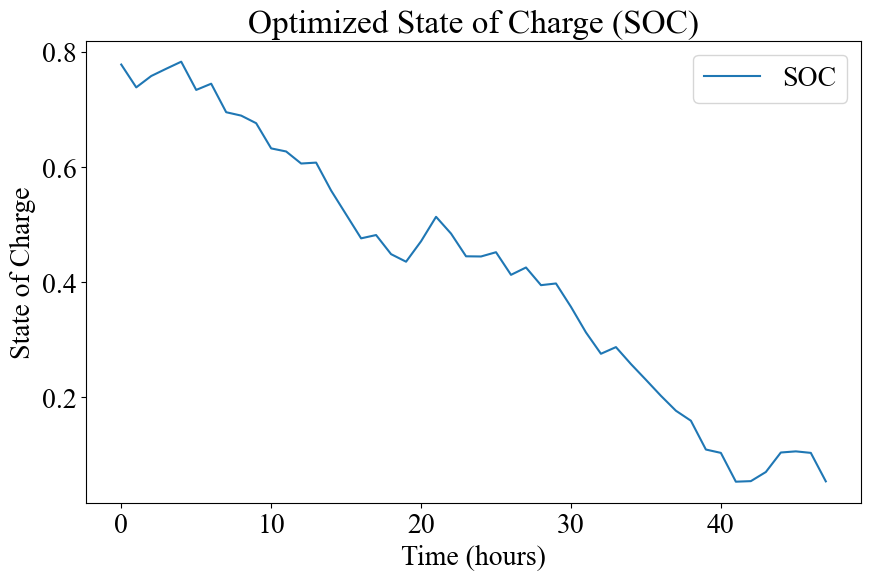

In [2]:
#QLD Testing


import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)


# Input data
# Normalize the inputs
P_pv = np.array( [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.58, 211.284, 550.175, 963.994, 1368.202, 1728.82, 2028.076, 2173.82, 2365.308, 2540.388, 2575.923, 2536.637, 2442.761, 2259.855, 2102.84, 1845.243, 1500.109, 1107.418, 687.743, 321.143, 80.799, 12.864, 0.59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])/1000
P_d = np.array([5840, 5655, 5550, 5499, 5433, 5376, 5424, 5492, 5579, 5675, 5899, 6101, 6513, 6818, 6835, 6629, 6254, 5825, 5450, 5156, 4981, 4959, 4893, 4871, 4929, 5065, 5100, 5162, 5340, 5603, 5904, 6294, 6714, 7060, 7340, 7591, 7602, 7558, 7394, 7299, 7149, 6920, 6787, 6554, 6363, 6174, 6115, 5909])/1000
#Cg_t = np.random.uniform(low=10, high=15, size=48)/1000
Cg_t =  np.array([94.53, 90.69, 83.43, 83.05, 78.61, 76.9, 75.27, 73.87, 79.05, 85.34, 95.44, 93.62, 127.56, 310.08, 153.59, 112.18, 74.29, 52.81, 50.76, 40.57, 29.59, 34.26, 26.64, 31.58, 32.52, 40.22, 43.79, 48.13, 57.44, 64.17, 66.33, 91.2, 135.77, 163.53, 600, 600, 372.43, 194.91, 151.28, 165.32, 154.06, 131.56, 121.15, 99.05, 108.73, 103.86, 105.46, 95.61])/100
Cb_t = np.random.uniform(low=0, high=20, size=48)/100

unc_P_pv= np.random.normal(loc=0, scale=0.10, size=48) * P_pv
unc_P_d= np.random.normal(loc=0, scale=0.10, size=48) * P_d
unc_Cg_t = np.random.normal(loc=0, scale=0.10, size=48) * Cg_t
unc_Cb_t= np.random.normal(loc=0, scale=0.10, size=48) * Cb_t


P_unc = unc_P_pv + unc_P_d + unc_Cg_t + unc_Cb_t

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -8
Pg_max = np.ones(48) * 7  # Example of maximum grid power
Pb_min = np.ones(48) * -1  # Example of minimum battery power
Pb_max = np.ones(48) * 1  # Example of maximum battery power
battery_capacity = 20  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.legend()
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)")
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)")
plt.ylabel("Value")
plt.legend()
plt.title("Optimized Alpha_g and Alpha_b")
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)")
plt.ylabel("State of Charge")
plt.legend()
plt.title("Optimized State of Charge (SOC)")
plt.show()


Converged after 99500 iterations.
Total cost: 10131.044921875
Number of SOC violations: 3
SOC at the end of the period: 0.22
Optimized Pg: [0.8987267  0.5801375  1.3883895  1.5        1.2558705  0.12042064
 1.5        0.23440391 0.90807235 1.0680461  0.3308112  1.3360498
 0.79083025 1.5        0.7054898  1.097218   0.9830555  1.5
 0.8931738  1.1842074  1.5        1.5        0.72527623 0.4698911
 1.371719   1.082819   0.5852688  1.3454938  0.46804795 1.066112
 0.68913186 0.4607204  0.7814001  1.5        1.2562743  1.5
 1.5        1.5        1.5        0.6154313  1.5        0.3602158
 1.5        1.5        1.5        1.5        1.3455988  0.26502863]
Optimized Pb: [ 0.10235478  0.41278467 -0.414808   -0.51228046 -0.22464858  0.9028115
 -0.5157389   0.797968    0.09761183 -0.05617736  0.7540829  -0.07279214
  0.41833547 -0.17194957  0.8180887   0.45004955  0.48924348 -0.05456121
  0.5435571   0.3021219  -0.10996228 -0.12892616  0.6027829   0.9083333
 -0.01372283  0.15196854  0.7454451  -0

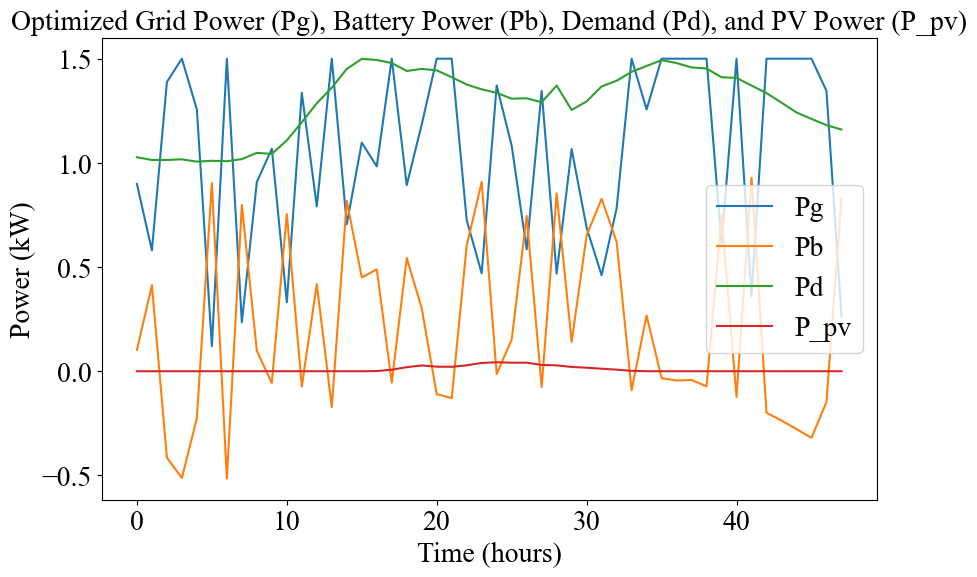

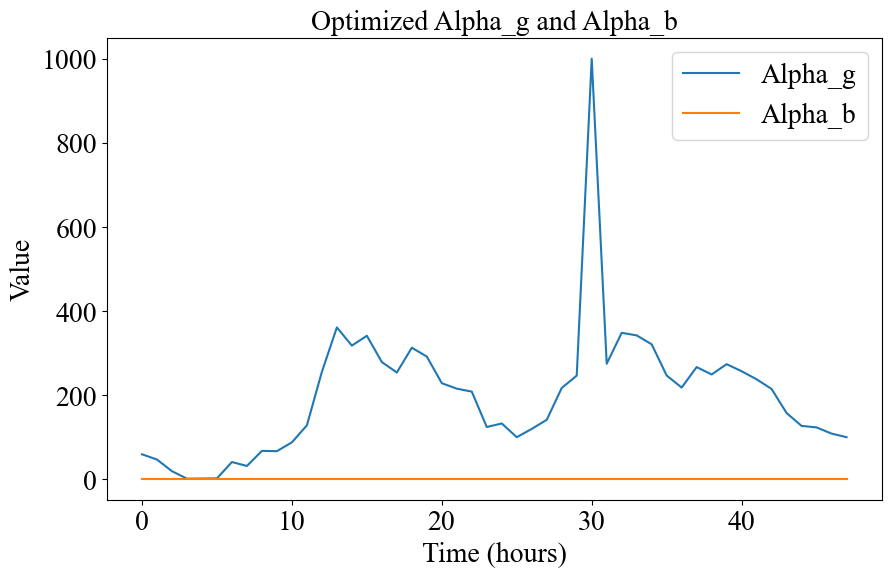

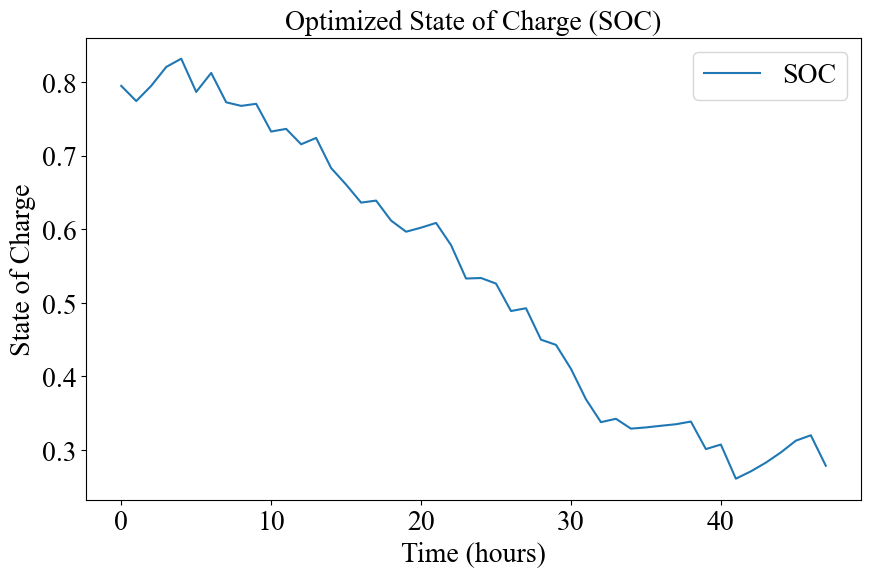

In [3]:
#TAS Testing 

import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Input data

P_pv = np.array( [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.825, 7.332, 19.469, 27.791, 21.822, 21.236, 28.424, 39.655, 43.19, 40.927, 41.08, 30.199, 28.195, 20.592, 16.817, 12.134, 7.618, 1.948, 0.059, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])/1000

P_d = np.array ([1027, 1014, 1014, 1017, 1006, 1010, 1008, 1018, 1048, 1043, 1108, 1195, 1286, 1361, 1451, 1499, 1494, 1479, 1441, 1451, 1444, 1411, 1376, 1353, 1336, 1308, 1310, 1291, 1371, 1254, 1295, 1367, 1394, 1437, 1465, 1493, 1479, 1458, 1453, 1411, 1408, 1371, 1335, 1289, 1242, 1211, 1181, 1160])/1000
#Cg_t = np.random.uniform(low=10, high=15, size=48)/1000
Cg_t =  np.array([22.61, 20.53, 15.97, 13.03, 13.09, 13.15, 19.57, 18.02, 23.94, 23.83, 27.29, 33.96, 54.96, 72.37, 65.25, 69.1, 58.78, 54.69, 64.42, 60.94, 50.5, 48.35, 47.19, 33.31, 34.7, 29.31, 32.57, 36.13, 48.62, 53.47, 177.81, 58.13, 70.26, 69.25, 65.75, 53.51, 48.78, 56.82, 53.92, 57.97, 55.19, 52.02, 48.22, 38.79, 33.74, 33.15, 30.72, 29.31])/100

Cb_t = np.random.uniform(low=0, high=20, size=48)/100

unc_P_pv= np.random.normal(loc=0, scale=0.10, size=48) * P_pv
unc_P_d= np.random.normal(loc=0, scale=0.10, size=48) * P_d
unc_Cg_t = np.random.normal(loc=0, scale=0.10, size=48) * Cg_t
unc_Cb_t= np.random.normal(loc=0, scale=0.10, size=48) * Cb_t


P_unc = unc_P_pv + unc_P_d + unc_Cg_t + unc_Cb_t

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -10
Pg_max = np.ones(48) * 1.5  # Example of maximum grid power
Pb_min = np.ones(48) * -1 # Example of minimum battery power
Pb_max = np.ones(48) * 1  # Example of maximum battery power
battery_capacity = 20  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())
#total_cost = np.sum(Pg_t.numpy() * Cg_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Power (kW)", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)", fontsize=20)
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Alpha_g and Alpha_b", fontsize=20)
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("State of Charge", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized State of Charge (SOC)", fontsize=20)
plt.show()








Converged after 99400 iterations.
Total cost: 20105.7734375
Number of SOC violations: 9
SOC at the end of the period: 0.02
Optimized Pg: [1.2987239e+00 1.1801333e+00 1.5000000e+00 1.5000000e+00 1.5000000e+00
 5.2041799e-01 1.5000000e+00 4.3440256e-01 1.3080696e+00 1.2680447e+00
 5.3080988e-01 1.3360498e+00 9.9082887e-01 1.5000000e+00 7.0548987e-01
 1.2972168e+00 1.3830526e+00 1.5000000e+00 1.0931726e+00 1.1842074e+00
 1.5000000e+00 1.5000000e+00 1.2528026e-01 9.9999346e-02 5.7172441e-01
 4.8282295e-01 9.9999458e-02 7.4549794e-01 4.4703484e-08 4.6611604e-01
 2.8913450e-01 2.6072171e-01 5.8140123e-01 1.5000000e+00 1.4562730e+00
 1.5000000e+00 1.5000000e+00 1.5000000e+00 1.5000000e+00 1.2154272e+00
 1.5000000e+00 9.6021187e-01 1.5000000e+00 1.5000000e+00 1.5000000e+00
 1.5000000e+00 1.5000000e+00 8.6502457e-01]
Optimized Pb: [ 0.16235436  0.3927848  -0.03480872 -0.07228379 -0.12464732  0.9028115
 -0.1857413   0.8379677   0.05761211  0.00382228  0.7540829  -0.03279136
  0.37833574  0.00805

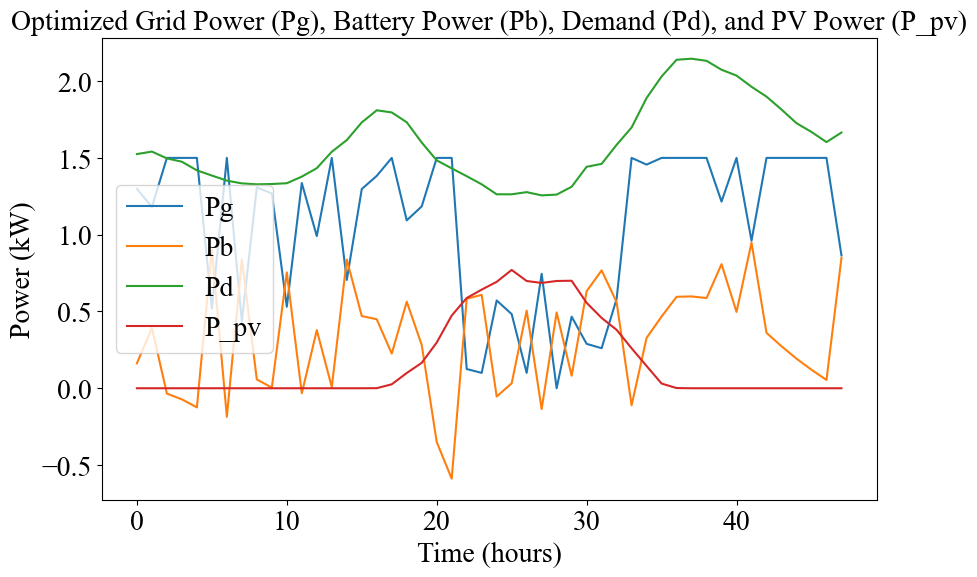

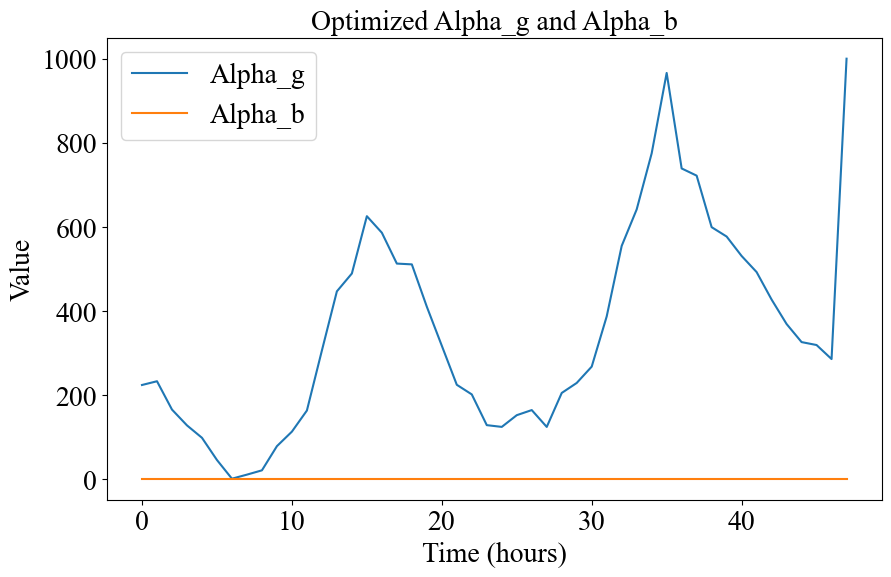

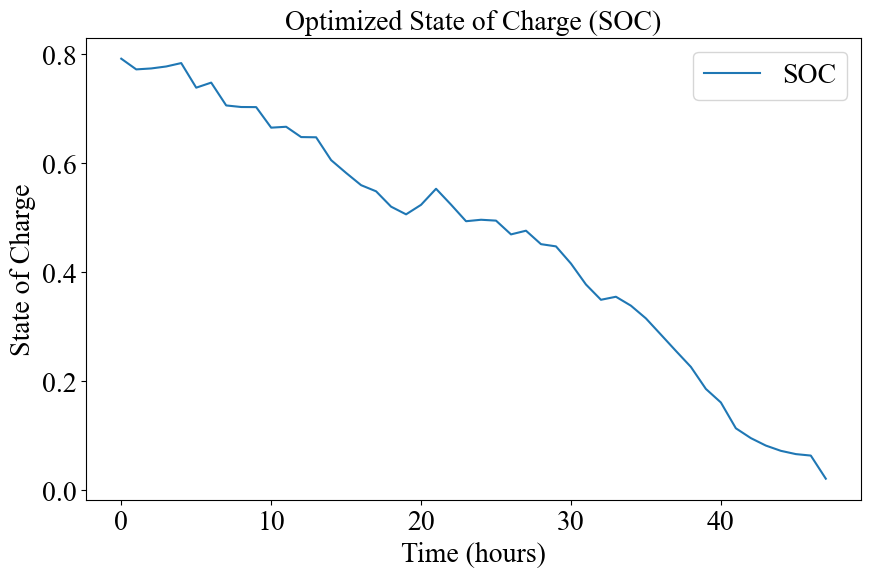

In [4]:
#SA Testing 

import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Input data

P_pv = np.array(  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.558, 25.748, 99.205, 165.586, 297.709, 473.272, 587.522, 642.254, 692.904, 770.326, 698.367, 685.698, 698.519, 700.014, 556.33, 458.006, 380.475, 260.294, 144.986, 30.575, 1.235, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])/1000

P_d = np.array ( [1525, 1541, 1497, 1475, 1419, 1385, 1352, 1334, 1328, 1330, 1335, 1378, 1433, 1540, 1616, 1731, 1810, 1796, 1732, 1600, 1484, 1432, 1381, 1328, 1263, 1263, 1277, 1256, 1261, 1312, 1442, 1461, 1585, 1698, 1890, 2030, 2139, 2146, 2132, 2074, 2036, 1963, 1899, 1815, 1726, 1669, 1603, 1665])/1000
#Cg_t = np.random.uniform(low=10, high=15, size=48)/1000
Cg_t =  np.array([66.86, 68.47, 56.32, 49.55, 44.23, 34.71, 26.7, 28.44, 30.28, 40.64, 46.87, 55.92, 81.63, 107, 114.65, 139.21, 132.13, 118.9, 118.56, 100.42, 83.68, 66.95, 62.82, 49.65, 48.9, 53.92, 56.11, 48.89, 63.45, 67.74, 74.74, 96.26, 126.48, 142.12, 166.15, 200.62, 159.67, 156.59, 134.51, 130.49, 122.16, 115.26, 103.48, 93, 85.25, 83.99, 77.98, 206.72])/100

Cb_t = np.random.uniform(low=0, high=20, size=48)/100

unc_P_pv= np.random.normal(loc=0, scale=0.10, size=48) * P_pv
unc_P_d= np.random.normal(loc=0, scale=0.10, size=48) * P_d
unc_Cg_t = np.random.normal(loc=0, scale=0.10, size=48) * Cg_t
unc_Cb_t= np.random.normal(loc=0, scale=0.10, size=48) * Cb_t


P_unc = unc_P_pv + unc_P_d + unc_Cg_t + unc_Cb_t

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -10
Pg_max = np.ones(48) * 1.5  # Example of maximum grid power
Pb_min = np.ones(48) * -1 # Example of minimum battery power
Pb_max = np.ones(48) * 1  # Example of maximum battery power
battery_capacity = 20  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())
#total_cost = np.sum(Pg_t.numpy() * Cg_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Power (kW)", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)", fontsize=20)
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Alpha_g and Alpha_b", fontsize=20)
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("State of Charge", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized State of Charge (SOC)", fontsize=20)
plt.show()








Converged after 106400 iterations.
Total cost: 39799.640625
Number of SOC violations: 4
SOC at the end of the period: 0.52
Optimized Pg: [4.746997  3.922704  4.5216484 4.424455  3.5180264 4.4724083 3.8579497
 4.1829414 4.3139143 3.3163946 3.1892853 3.6830401 4.257283  4.940647
 6.226039  6.4839215 6.365333  6.591318  6.8335543 6.5450068 4.985782
 5.8020267 4.2149816 5.6067104 5.389412  5.396071  3.8720999 4.6048684
 3.7476661 4.099389  4.34248   4.835544  6.0670915 6.9000006 7.
 6.9000006 6.9000006 6.8944106 6.3131247 6.220015  6.351117  6.442602
 6.4251246 4.792629  5.9306145 4.536965  4.7728176 4.4485855]
Optimized Pb: [-0.09521666  0.568943   -0.15283155 -0.37620187  0.53423625 -0.4703052
  0.03263189 -0.26136798 -0.47431332  0.7943826   1.          0.6516712
  0.7231116   0.5180949  -0.28371003 -0.2478013   0.04448076 -0.28553343
 -0.6450254  -0.48314846  0.7611866  -0.4671486   0.9311588  -0.7361065
 -0.7309566  -0.79079413  0.5540942  -0.4392661   0.17107669  0.20473696
  0.47110

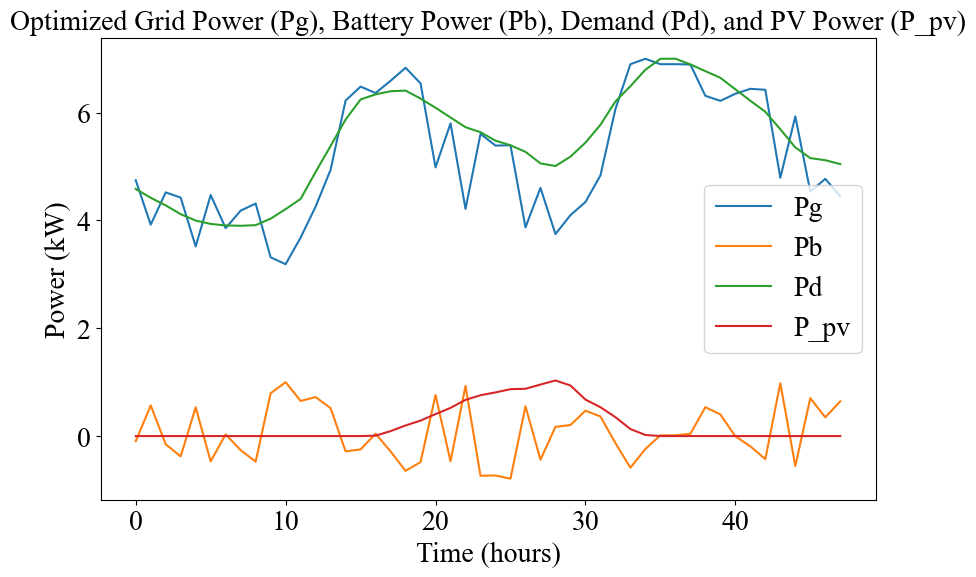

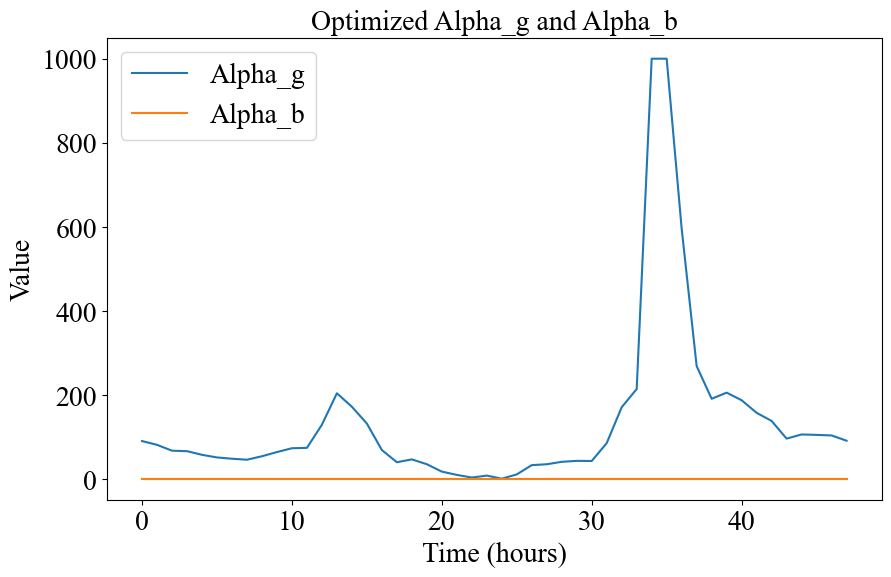

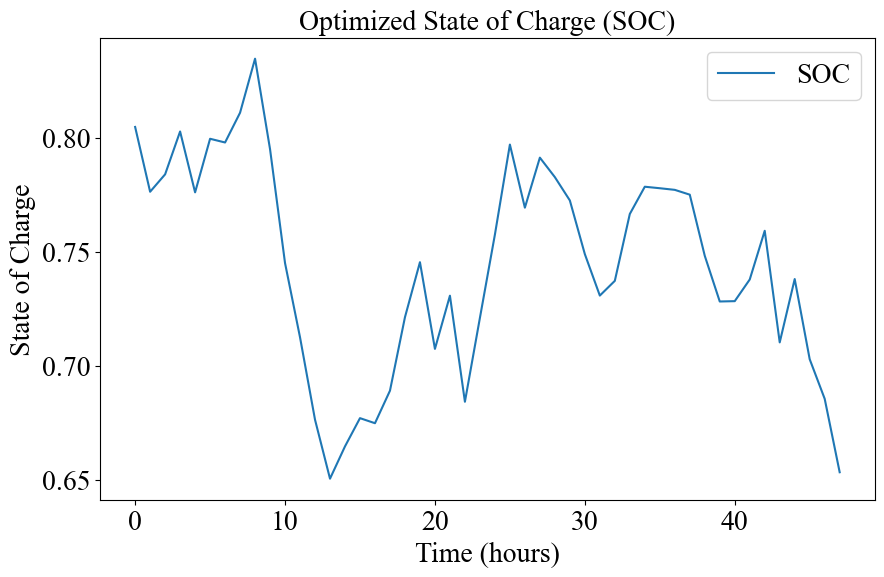

In [5]:
#NSW Testing 

import numpy as np
import tensorflow as tf
import time
# Set the random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
# Input data

P_pv = np.array( [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.005, 7.811, 91.952, 196.79, 286.966, 407.908, 523.096, 671.067, 758.398, 809.97, 870.232, 877.408, 955.78, 1031.802, 938.662, 677.735, 535.202, 350.939, 130.108, 20.367, 0.655, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])/1000

P_d = np.array([4586, 4421, 4280, 4117, 3999, 3936, 3908, 3902, 3913, 4034, 4211, 4400, 4900, 5383, 5872, 6246, 6340, 6398, 6410, 6262, 6092, 5911, 5731, 5638, 5481, 5395, 5274, 5059, 5011, 5184, 5444, 5775, 6208, 6492, 6797, 7000, 7002, 6896, 6771, 6648, 6434, 6222, 6017, 5693, 5356, 5157, 5119, 5046])/1000
#Cg_t = np.random.uniform(low=10, high=15, size=48)/1000
Cg_t =  np.array([98.12, 93.17, 85.48, 84.82, 80.07, 76.62, 74.93, 73.62, 78.18, 83.64, 88.69, 89.19, 119.49, 160.82, 143.17, 121.11, 86.37, 70.31, 74.08, 67.7, 58.03, 53.71, 50.24, 52.76, 48.72, 54.35, 66.5, 67.68, 70.86, 72.13, 71.96, 95.4, 142.51, 166.38, 600, 600, 377.04, 196.59, 153.62, 161.65, 151.72, 135.17, 124.55, 101.33, 106.77, 106.22, 105.48, 98.56])/100

Cb_t = np.random.uniform(low=0, high=20, size=48)/100

unc_P_pv = np.random.uniform(low=0, high=0.01, size=48) * P_pv
unc_P_d = np.random.uniform(low=0, high=0.01, size=48) * P_d
unc_Cg_t = np.random.uniform(low=0, high=0.01, size=48) * Cg_t
unc_Cb_t = np.random.uniform(low=0, high=0.01, size=48) * Cb_t

P_unc = unc_P_pv + unc_P_d + unc_Cg_t + unc_Cb_t

def update_alpha_g(Cg, alpha_g_min, alpha_g_max):
    dtype = Cg.dtype
    normalized_Cg = (Cg - tf.reduce_min(Cg)) / (tf.reduce_max(Cg) - tf.reduce_min(Cg))
    return tf.cast(alpha_g_min, dtype=dtype) + normalized_Cg * (tf.cast(alpha_g_max, dtype=dtype) - tf.cast(alpha_g_min, dtype=dtype))




def enforce_battery_constraints(Pb):
    SOC_t = initial_SOC - tf.cumsum(Pb) / battery_capacity
    SOC_t_normalized = tf.clip_by_value(SOC_t, 0.0, 1.0)
    return SOC_t_normalized


def Pg_Pb_loss(Pg, Pb):
    Pg = tf.cast(Pg, dtype=tf.float32)
    Pb = tf.cast(Pb, dtype=tf.float32)
    
    SOC_t_normalized = enforce_battery_constraints(Pb)

    loss = tf.reduce_sum(alpha_g_t * tf.square(tf.nn.relu(Pg - Pg_max)) + alpha_b_t * tf.square(tf.nn.relu(Pb - Pb_max)))

    # Introduce a penalty term for SOC violation (below 20% or above 80%)
    soc_violation_penalty = tf.reduce_sum(tf.square(tf.nn.relu(0.2 - SOC_t_normalized)) + tf.square(tf.nn.relu(SOC_t_normalized - 0.8))) * 10.0
    alpha_b_penalty = alpha_b_t * soc_violation_penalty
    power_balance_penalty = tf.reduce_sum(tf.square(P_d - (Pg_t + Pb_t) - P_pv)) * 10000

    # Add a penalty term to make alpha_g_t depend on Cg_t values
    alpha_g_penalty_weight = 100  # Adjust this value to control the impact of the penalty term
    alpha_g_penalty = alpha_g_penalty_weight * tf.reduce_sum(tf.square(tf.cast(alpha_g_t, tf.float32) - tf.cast(update_alpha_g(Cg_t, alpha_g_min, alpha_g_max), tf.float32)))
     # Add a penalty term to enforce SOC at the end of the period to be above 0.8
    end_soc_penalty_weight = 10000 # Adjust this value to control the impact of the penalty term
    end_soc_penalty = end_soc_penalty_weight * tf.square(tf.nn.relu(0.8 - SOC_t_normalized[-1]))

    return loss + alpha_b_penalty + power_balance_penalty + alpha_g_penalty + end_soc_penalty






def optimize_with_schedule(loss_function, var, bounds, initial_lr, decay_steps, decay_rate, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)

    for _ in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(var)
        grads = tape.gradient(loss, [var])
        optimizer.learning_rate.assign(lr_schedule(optimizer.iterations))
        optimizer.apply_gradients(zip(grads, [var]))
        bounds_np = np.array(bounds)
        project_constraints(var, bounds_np[:, 0], bounds_np[:, 1])


    return var


def project_constraints(var, lower_bound, upper_bound):
    var.assign(tf.clip_by_value(var, lower_bound, upper_bound))


# Initialize variables
num_epochs = 5000000
tolerance = 1e-5
loss_prev = np.inf
Pg_min = np.zeros(48)* -10
Pg_max = np.ones(48) * 7  # Example of maximum grid power
Pb_min = np.ones(48) * -1 # Example of minimum battery power
Pb_max = np.ones(48) * 1  # Example of maximum battery power
battery_capacity = 20  # Example of battery capacity
Pg_t = tf.Variable(np.random.uniform(Pg_min, Pg_max, 48), dtype=tf.float32)
Pb_t = tf.Variable(np.random.uniform(Pb_min, Pb_max, 48), dtype=tf.float32)
alpha_g_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_b_t = tf.Variable(np.random.uniform(1, 1000, 48), dtype=tf.float32)
alpha_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

epsilon = 1e-8  # Small positive value
alpha_g_min, alpha_g_max = 1, 1000  # Define the minimum and maximum values for alpha_g


initial_SOC = 0.8 



start_time = time.time()
for epoch in range(num_epochs):
    Pg_t = optimize_with_schedule(lambda x: Pg_Pb_loss(x, Pb_t), Pg_t, list(zip(Pg_min, Pg_max)), initial_lr=0.1, decay_steps=100, decay_rate=0.95, num_epochs=1)
    Pb_t = optimize_with_schedule(lambda x: Pg_Pb_loss(Pg_t, x), Pb_t, list(zip(Pb_min, Pb_max)), initial_lr=0.01, decay_steps=100, decay_rate=0.95, num_epochs=1)
    
    # Ensure Pg_t is non-zero during high tariff periods
    Pg_t.assign(tf.clip_by_value(Pg_t, tf.where(alpha_g_t > 0.5, epsilon, 0.0), Pg_max))

    # Optimize alpha_g_t and alpha_b_t for the next time step
    with tf.GradientTape() as tape:
        loss = Pg_Pb_loss(Pg_t, Pb_t)
    grads = tape.gradient(loss, [alpha_g_t, alpha_b_t])

    # Update alpha_g_t and alpha_b_t using the Adam optimizer
    alpha_opt.apply_gradients(zip(grads, [alpha_g_t, alpha_b_t]))

    # Project alpha_g_t and alpha_b_t back to the desired range [1, 1000]
    project_constraints(alpha_g_t, np.ones(48), np.ones(48) * 1000)
    project_constraints(alpha_b_t, np.ones(48), np.ones(48) * 1000)

    # Check for convergence
    if epoch % 100 == 0:
        if np.all(np.abs(loss.numpy() - loss_prev) < tolerance):
            print(f"Converged after {epoch} iterations.")
            break
        loss_prev = loss.numpy()


end_time = time.time()
# Calculate the total cost (electricity bill)
total_cost = np.sum(Pg_t.numpy() * alpha_g_t.numpy())
#total_cost = np.sum(Pg_t.numpy() * Cg_t.numpy())

    # Calculate SOC violations and SOC at the end of the period
SOC_t_normalized = enforce_battery_constraints(Pb_t)
soc_violations = np.sum((SOC_t_normalized.numpy() < 0.2) | (SOC_t_normalized.numpy() > 0.8))
soc_target = SOC_t_normalized.numpy()[-1] * 0.8

print(f"Total cost: {total_cost}")
print(f"Number of SOC violations: {soc_violations}")
print(f"SOC at the end of the period: {soc_target:.2f}")




# Print the optimized values
print(f"Optimized Pg: {Pg_t.numpy()}")
print(f"Optimized Pb: {Pb_t.numpy()}")
print(f"Optimized alpha_g: {alpha_g_t.numpy()}")
print(f"Optimized alpha_b: {alpha_b_t.numpy()}")
# Calculate and print the SOC
SOC_t_normalized = enforce_battery_constraints(Pb_t)
print(f"SOC: {SOC_t_normalized.numpy()}")
print(f"Total optimization time: {end_time - start_time} seconds")


import matplotlib.pyplot as plt

# Set font properties
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# Plot Pg, Pb, Pd, and Ppv
plt.figure(figsize=(10, 6))
plt.plot(Pg_t.numpy(), label="Pg")
plt.plot(Pb_t.numpy(), label="Pb")
plt.plot(P_d, label="Pd")
plt.plot(P_pv, label="P_pv")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Power (kW)", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Grid Power (Pg), Battery Power (Pb), Demand (Pd), and PV Power (P_pv)", fontsize=20)
plt.show()

# Plot alphas
plt.figure(figsize=(10, 6))
plt.plot(alpha_g_t.numpy(), label="Alpha_g")
plt.plot(alpha_b_t.numpy(), label="Alpha_b")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized Alpha_g and Alpha_b", fontsize=20)
plt.show()

# Plot SOC
plt.figure(figsize=(10, 6))
plt.plot(SOC_t_normalized.numpy(), label="SOC")
plt.xlabel("Time (hours)", fontsize=20)
plt.ylabel("State of Charge", fontsize=20)
plt.legend(fontsize=20)
plt.title("Optimized State of Charge (SOC)", fontsize=20)
plt.show()






